# Generating window aggregated data

## Imports

In [1]:
import os
import random
import calendar
import datetime
import warnings
import numpy as np
import pandas as pd
from datetime import timedelta
from collections import Counter
from google.cloud import bigquery

from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets

import scipy.stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")
tqdm.pandas()

In [2]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Config

In [3]:
# Config

PROJECT_ID = "arpae-prod-ml"

# BigQuery
JOINED_BQ_DATASET = "JOINED_DATA"
JOINED_DATA_TABLE = "ALL_METEO_FEATS_POL_DAT"
B_CODES_TABLE = "B_CODES"

# Ouput
model_output = "models"

## Methods

In [4]:
# Read Methods

def _run_query(client, query):
    df = client.query(query).to_dataframe()
    return df

def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

# 1. Read Data

## 1.1 Config BigQuery

In [5]:
# Setup Client

bq_client = bigquery.Client.from_service_account_json("../data/arpae-prod-ml-f7820c528250.json")
bq_client

___

## Eligible Table

In [6]:
# Load B_CODES

sql = f"SELECT * FROM `{PROJECT_ID}.SAMPLE_DATA.{B_CODES_TABLE}` WHERE eligible IS true"
b_codes = _run_query(bq_client, sql)

print(b_codes.shape)
b_codes.head(3)

(33, 3)


,var_id,var_descr,eligible
0,B48026,"Mirtacee_Mirtacee indistinte, POLLEN/M**3",True
1,B48006,"Composite_Artemisia, POLLEN/M**3",True
2,B48041,"Spore fungine_Stemphylium, POLLEN/M**3",True


___

In [7]:
### POL_DAT

sql = """
SELECT *
FROM `arpae-prod-ml.JOINED_DATA.POL_DAT`
WHERE pol_var_id IN ({})
""".format(', '.join("'" + item + "'" for item in b_codes.var_id))

df_pol_dat = _run_query(bq_client, sql)

print(df_pol_dat.shape)
df_pol_dat.head(3)

(2645657, 19)


,id_gepo,date,pol_var_id,pol_value,reftime,modified,station_id,station_lat,station_lon,station_nome,station_H_piano_strada,station_H_mslm,arkimet_id,arkimet_lat,arkimet_lon,meteo_id,pol_var_descr,week,year
0,1,2021-08-23,B48002,18.48,2021-08-23 00:00:00+00:00,2,15,44.45,11.5,test,10.0,10.0,None,NaN,NaN,None,"Betulacee_Ontano nero, POLLEN/M**3",34,2021
1,1,2021-08-24,B48002,24.64,2021-08-24 00:00:00+00:00,2,15,44.45,11.5,test,10.0,10.0,None,NaN,NaN,None,"Betulacee_Ontano nero, POLLEN/M**3",34,2021
2,1,2021-08-25,B48002,30.80,2021-08-25 00:00:00+00:00,2,15,44.45,11.5,test,10.0,10.0,None,NaN,NaN,None,"Betulacee_Ontano nero, POLLEN/M**3",34,2021


___

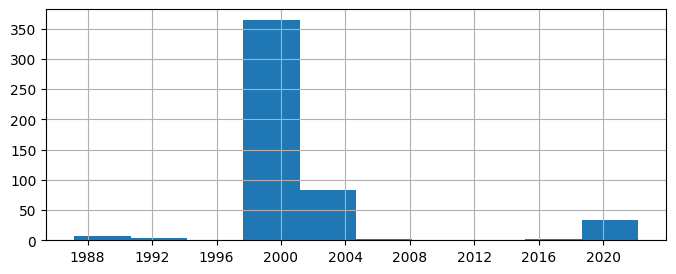

In [8]:
plt.figure(figsize=(8,3))
df_pol_dat.groupby(["station_id", "pol_var_id"]).date.apply(min).hist();

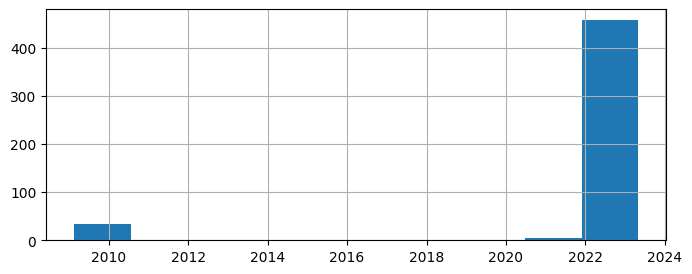

In [9]:
plt.figure(figsize=(8,3))
df_pol_dat.groupby(["station_id", "pol_var_id"]).date.apply(max).hist();

In [10]:
dates = df_pol_dat.groupby(["station_id", "pol_var_id"]).date.agg([min, max]).reset_index()
dates.head(5)

,station_id,pol_var_id,min,max
0,1,B48001,1999-03-01,2023-04-30
1,1,B48002,1999-01-02,2023-04-30
2,1,B48003,1999-01-02,2023-04-30
3,1,B48005,1999-04-01,2023-04-30
4,1,B48006,1999-04-01,2023-04-30


In [11]:
df_pol_dat.date.dtype

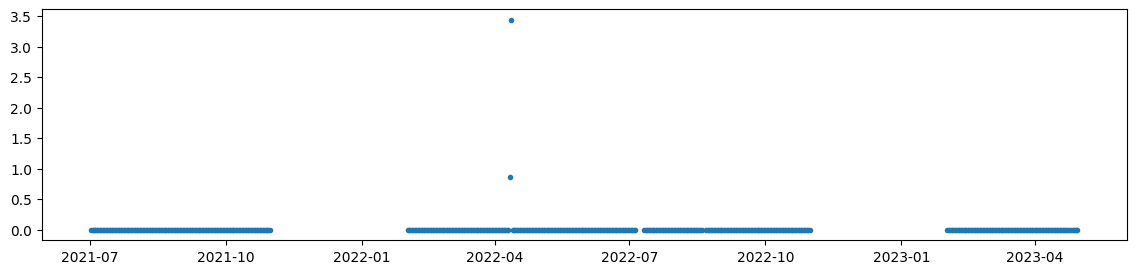

In [12]:
sample = df_pol_dat[(df_pol_dat.station_id == 13) & (df_pol_dat.pol_var_id == "B48045")]
sample.sort_values("date", inplace=True)
sample.date = pd.to_datetime(sample.date)

#sample = sample.iloc[-500:]
sample = sample[sample.date > pd.to_datetime("2021-07-01")]

plt.figure(figsize=(14, 3))
plt.plot(sample.date, sample.pol_value, ".");

In [13]:
### Is the same happening in our final dataset?
df_def = pd.read_feather("../data/dataset_7D_normalized_2023.feather")
df_def.date.dtype

datetime64[ns, UTC]

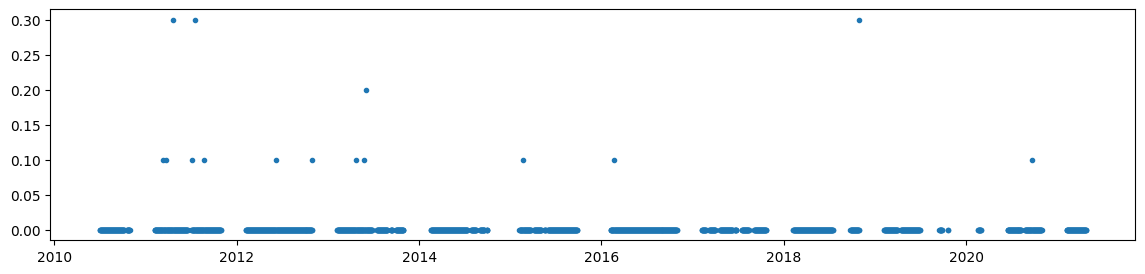

In [14]:
sample = df_def[(df_def.station_id == 13) & (df_def.pol_var_id == "B48045")]
sample.sort_values("date", inplace=True)

from db_dtypes import DateDtype
sample.date = pd.to_datetime(sample.date).dt.date.astype(DateDtype())

#sample = sample.iloc[-500:]
sample = sample[sample.date > pd.to_datetime("2010-07-01").date()]

plt.figure(figsize=(14, 3))
plt.plot(sample.date, sample.pol_value_label, ".");

In [ ]:
### Check if we have meteo for these. If there's not, that's our problem

df_meteo = 

0it [00:00, ?it/s]

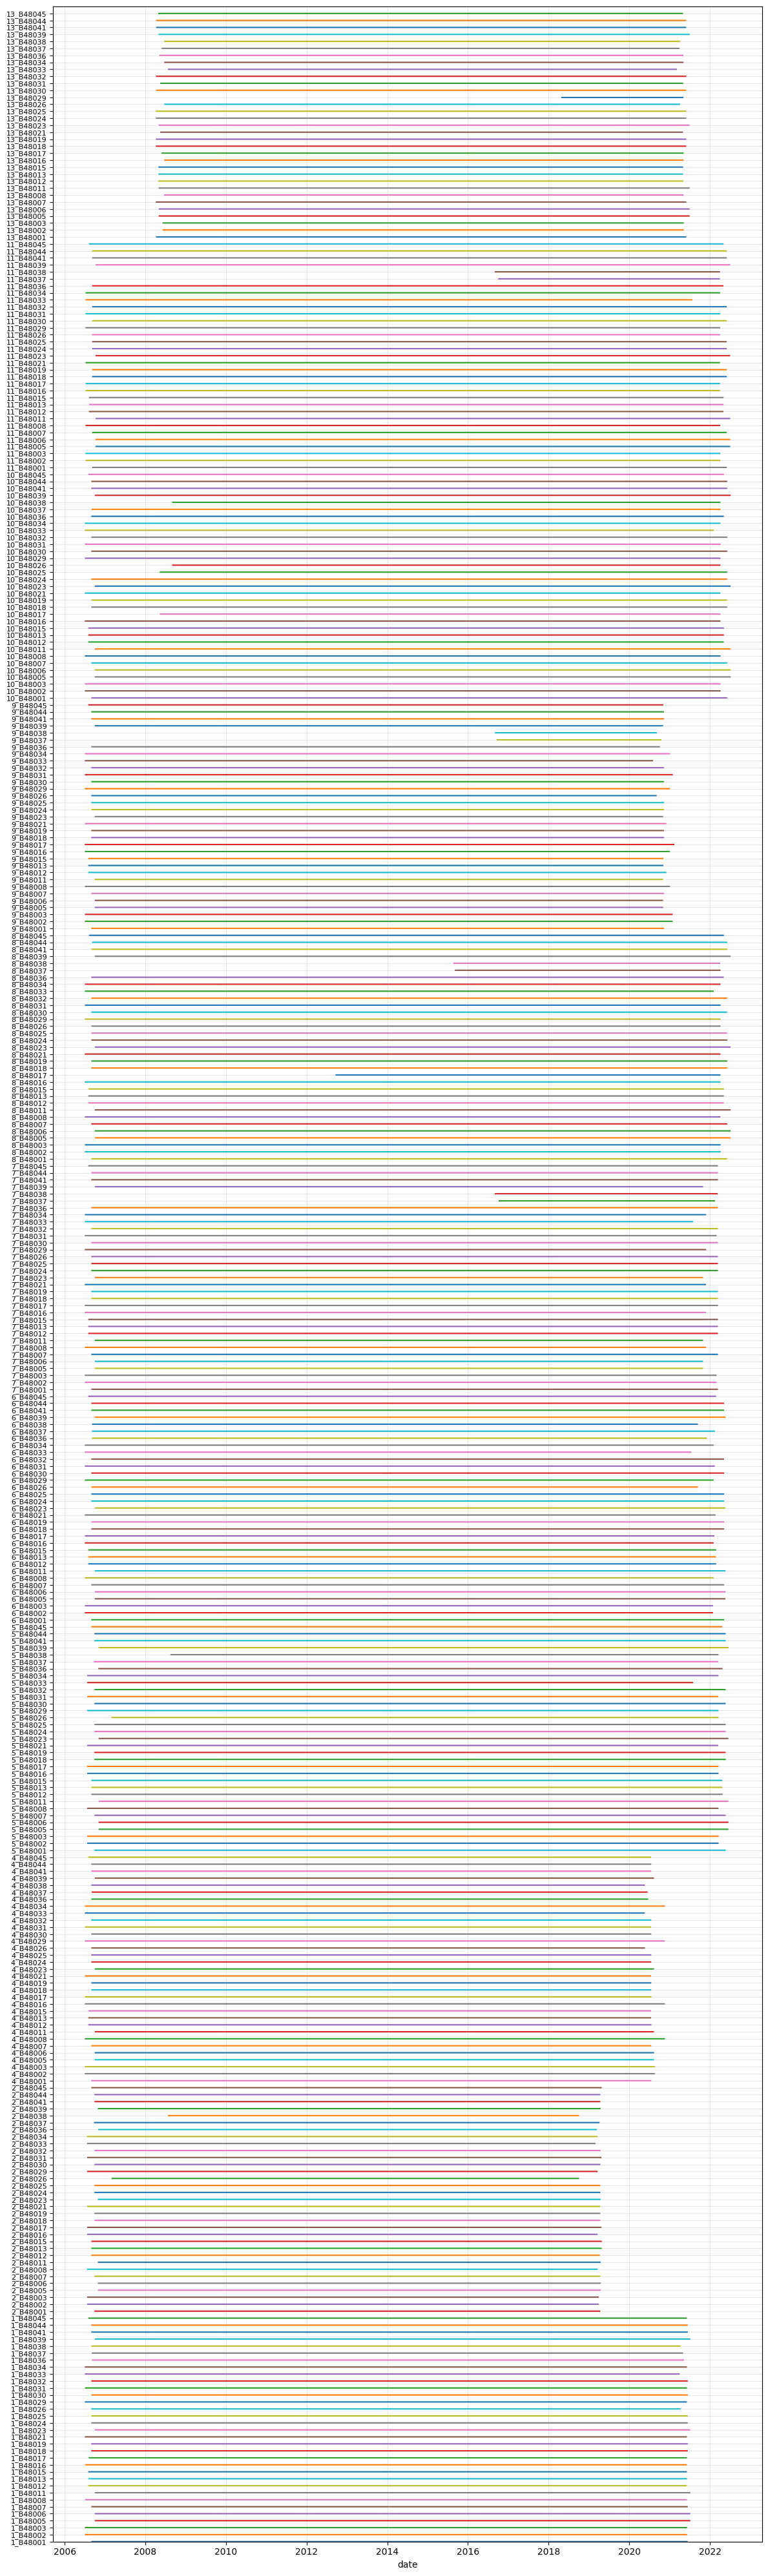

In [90]:
plt.figure(figsize=(12,40))
gids = []
for idx, (_, group) in tqdm(enumerate(df_def.groupby(["station_id","pol_var_id"]))):
    gids.append(f"{group.iloc[0].station_id}_{group.iloc[0].pol_var_id}")
    sns.lineplot(x="date", y=idx, data=group, legend=False)# if idx > 0 else True)

ax = plt.gca()
ax.set_yticks(range(len(gids)))
ax.set_yticklabels(gids, fontsize=8)
# ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.ylim(0, len(gids))
plt.tight_layout()
plt.grid(alpha=.3)
plt.show()

In [37]:
all_pairs = df_pol_dat[["station_id", "pol_var_id"]].drop_duplicates()

print(all_pairs.shape)
all_pairs.head(5)

(495, 2)


,station_id,pol_var_id
0,15,B48002
7,15,B48031
14,7,B48001
21,7,B48006
22,7,B48007


In [ ]:
selected = df_pol_dat.groupby(["station_id", "pol_var_id"])

In [ ]:
how_many_left = how_many_left[["station_id", "pol_var_id"]].drop_duplicates()

print(how_many_left.shape)
how_many_left.head(5)

___

___